### Sequence-to-Sequence (seq2seq) :
seq2seq models : are used for a variety of NLP tasks, such as : text summarization, speech recognition,
DNA sequence modeling, NER (Named Entity Recognition) , Chatbot skills to have conversational ability and 
engage with customers , Question Answering systems. 
Here we translate given sentences from one language to another.                                                     

A typical seq2seq model has 2 major components –                                                                               
a) an encoder (Input Sequence)                                                                                             
b) a decoder (Output Squence)                                                                                                

Both these parts are essentially two different recurrent neural network (RNN) models combined into one giant network:

<img src='enc_dec_2.png'>

#### Here we convert a 'German sentence to its English' using a Neural Machine Translation (NMT) system, through Seq2Seq model using Keras.

#### Get the data 'German-English' sentence pairs data from here : http://www.manythings.org/anki/.

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
%matplotlib inline

import string
import re

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers

Using TensorFlow backend.


### 1st we will read the file , Our data is a text file (.txt) of English-German sentence pairs. 

In [2]:
# with open('deu.txt', mode='rt', encoding='utf-8') as f:                           # 1. python 'with open' method
#     data = f.read()

In [3]:
data = pd.read_csv('deu.txt', encoding='utf-8', sep='\t', header=None, names=['eng', 'ger'])    # 2. using pandas method
data.head()

,eng,ger
0,Hi.,Hallo!
1,Hi.,Grüß Gott!
2,Run!,Lauf!
3,Wow!,Potzdonner!
4,Wow!,Donnerwetter!


In [4]:
deu_eng = np.array(data)       # read the text into an array 

#### The actual data contains more than 150,000 sentence-pairs. However, we will use only the first 20,000 sentence pairs to reduce the training time of the model.

In [5]:
deu_eng = deu_eng[:20000, :]             # using only 20000 sentences
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Sign the contract.', 'Unterschreibt den Vertrag.'],
       ['Silence is golden.', 'Schweigen ist Gold.'],
       ['Silk is expensive.', 'Seide ist teuer.']], dtype=object)

### Now we will remove the punctuations and then convert all the text to lower case.

In [6]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [7]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

In [8]:
deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['sign the contract', 'unterschreibt den vertrag'],
       ['silence is golden', 'schweigen ist gold'],
       ['silk is expensive', 'seide ist teuer']], dtype=object)

### A Seq2Seq model requires that convert both the input and the output sentences into integer sequences of fixed length. But 1st we will capture the lengths of all the sentences in two separate lists for English and German.

In [9]:
eng_l = [len(i.split()) for i in deu_eng[:,0]]   # english sentence length list
deu_l = [len(i.split()) for i in deu_eng[:,1]]   # german sentence length list

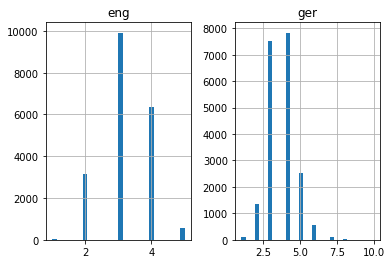

In [10]:
length_df = pd.DataFrame({'eng':eng_l, 'ger':deu_l})     # creating dataframe of length of both lists and plot it.

length_df.hist(bins=30)
plt.show()

#### The maximum length of the German sentences is 8 and that of the English phrases is 5.

### Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

In [11]:
def tokenization(lines):                         # function to build a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [12]:
eng_tokenizer = tokenization(deu_eng[:, 0])               # english tokenizer 
eng_vocab_size = len(eng_tokenizer.word_index) + 1        # gives length

deu_tokenizer = tokenization(deu_eng[:, 1])              # german tokenizer
deu_vocab_size = len(deu_tokenizer.word_index) + 1       # length of it 

In [13]:
eng_length = 5
deu_length = 5

print('English Vocabulary Size: ', eng_vocab_size)
print('Deutch Vocabulary Size: ', deu_vocab_size)

English Vocabulary Size:  3707
Deutch Vocabulary Size:  5822


### This function to prepare the sequences. It also perform sequence padding to a maximum sentence length.

In [14]:
def encode_sequences(tokenizer, length, lines):                  # encode and pad sequences
    
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### split the data into train and test set 

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

### Now we encode 'German sentences' as the input sequences and 'English sentences' as the target sequences. This has to be done for both the train and test datasets.

In [16]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

#### Seq2Seq model architecture:

->For the encoder, we will use an embedding layer and an LSTM layer.                                                          
->For the decoder, we will use another LSTM layer followed by a Dense layer.

<img src='seq2seq.png'>

## Build the Model

In [17]:
model = Sequential()
model.add(Embedding(deu_vocab_size, 512, input_length=deu_length, mask_zero=True))
model.add(LSTM(512))
model.add(RepeatVector(eng_length))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(eng_vocab_size, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 512)            2980864   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 5, 3707)           1901691   
Total params: 9,080,955
Trainable params: 9,080,955
Non-trainable params: 0
_________________________________________________________________


In [18]:
rms = optimizers.RMSprop(lr=0.001)     # RMSprop optimizer goes well with RNN

model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

#### Note : that we have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.

#### We are also using the ModelCheckpoint() function to save the model with the lowest validation loss.

In [19]:
filename = 'model.seq2seq'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=20, batch_size=512, 
                    validation_split=0.2, callbacks=[checkpoint], verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 12800 samples, validate on 3200 samples
Epoch 1/20
 1024/12800 [=>............................] - ETA: 23:08 - loss: 8.2047

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (18.010302). Check your callbacks.
  % delta_t_median)


12800/12800 [==============================] - 229s 18ms/step - loss: 5.0502 - val_loss: 4.1020

Epoch 00001: val_loss improved from inf to 4.10195, saving model to model.seq2seq
Epoch 2/20
12800/12800 [==============================] - 88s 7ms/step - loss: 3.9166 - val_loss: 3.9254

Epoch 00002: val_loss improved from 4.10195 to 3.92543, saving model to model.seq2seq
Epoch 3/20
12800/12800 [==============================] - 89s 7ms/step - loss: 3.7507 - val_loss: 3.8036

Epoch 00003: val_loss improved from 3.92543 to 3.80364, saving model to model.seq2seq
Epoch 4/20
12800/12800 [==============================] - 90s 7ms/step - loss: 3.6435 - val_loss: 3.7004

Epoch 00004: val_loss improved from 3.80364 to 3.70039, saving model to model.seq2seq
Epoch 5/20
12800/12800 [==============================] - 89s 7ms/step - loss: 3.4954 - val_loss: 3.6047

Epoch 00005: val_loss improved from 3.70039 to 3.60468, saving model to model.seq2seq
Epoch 6/20
12800/12800 [=============================

### compare the training loss and the validation loss.

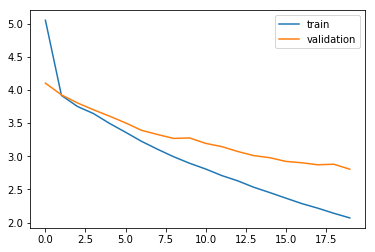

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train','validation'])
plt.show()

#### the validation loss stopped decreasing after 15 epochs

### Now we load the saved model and make predictions on the data – testX.

In [21]:
model = load_model('model.seq2seq')    # load the model

pred = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))    # predict on 'testX' data

In [22]:
pred               # These predictions are sequence of integers.

array([[   1,    3,    0,    0,    0],
       [   7,   44,   11,    0,    0],
       [   8,   10,   13,    0,    0],
       ...,
       [  64,    6, 1268,    0,    0],
       [   5,   10,    0,    0,    0],
       [   7,    6,   11,    0,    0]], dtype=int64)

#### Converting these integers to their corresponding words

In [23]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [24]:
# Convert 'pred' predictions into text (English)

preds_text = []     # store in this text
for i in pred:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [29]:
# Now put the original and predicted sentences in a dataframe and compare it.

pred_df = pd.DataFrame({'actual':test[:,0], 'predicted':preds_text})    # DF of actual and predicted

pred_df.sample(10)       # print some randomly 

,actual,predicted
3026,dont go tom,dont go tom
355,then what,dont it me
2348,tom painted this,tom has it
2686,ill protect tom,ill called tom
708,tom ate alone,tom looked me
3995,tom is breathing,tom is
484,her story is true,the is
308,what is love,what is to
1789,tom will follow,tom is
1742,that will do,its is


#### Seq2Seq model does a good job. But there are several instances where it misses out on understanding the key words. I have taken 20000 sentences only. So, we can mitigate such challenges by using more training data and building a better (or more complex) model.